In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import os
import math
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_context("notebook")
from scipy.stats import norm
from sklearn.cluster import KMeans
import pylab 
import scipy.stats as stats
import networkx as nx

DATA_DIR = 'data'

In [2]:
# load the mean tone a country has about itself
country_to_country_view = pd.read_csv(os.path.join(DATA_DIR, 'country_to_country_view.csv')).dropna()  # 3 rows have no mention_country
country_inner_view = pd.read_csv(os.path.join(DATA_DIR, 'country_inner_view.csv'))
country_outer_view = pd.read_csv(os.path.join(DATA_DIR, 'country_outer_view.csv'))
country_inner_type_view = pd.read_csv(os.path.join(DATA_DIR, 'country_inner_type_view.csv'))
country_outer_type_view = pd.read_csv(os.path.join(DATA_DIR, 'country_outer_type_view.csv'))
country_to_type_view = pd.read_csv(os.path.join(DATA_DIR, 'country_to_country_type_view.csv'))
media_to_country_view = pd.read_csv(os.path.join(DATA_DIR, 'media_to_country_view.csv.zip'))

##EXPLORATION

In order to better understand our dataset, it’s important to take into account the count of mentions of each country. In fact we have to be very careful when we will conclude about a phenomenon because a small count of count_event for a country can lead us down to a wrong path.

In [3]:
# count the event by interval

# create a dataframe with two column, country and interval
count_event_by_interval = pd.DataFrame(columns=['country','interval'])
# we take all the possible name for a country
country = country_inner_view["country"].values
# for each country
for i in country:
        # we compute the total count_mentions from the outer_view and inner_view
        total_count_mention = country_outer_view[country_outer_view["country"] == i]["count_mentions"].values + country_inner_view["count_mentions"][country_inner_view["country"] == i].values
        if (total_count_mention < 10000):
            value = 0
        if ( 9999 < total_count_mention < 100000):
            value = 1
        if (99999 < total_count_mention < 10000000 ) :
            value = 2
        if (999999 < total_count_mention ) :
            value = 3
        count_event_by_interval = count_event_by_interval.append({'country': i, 'interval' : value}, ignore_index=True)


# variable initialization
val_0=0
val_1=0
val_2=0
val_3=0

for i in country :
    if (count_event_by_interval[count_event_by_interval["country"]==i]["interval"].values == 0 ):
        val_0 = val_0 +1
    if (count_event_by_interval[count_event_by_interval["country"]==i]["interval"].values == 1 ):
        val_1 = val_1 +1
    if (count_event_by_interval[count_event_by_interval["country"]==i]["interval"].values == 2 ):
        val_2 = val_2 +1
    if (count_event_by_interval[count_event_by_interval["country"]==i]["interval"].values == 3 ):
        val_3 = val_3 +1

# create a dataframe for the plot
final_count_mentions = pd.DataFrame(columns=['total country','number of mentions'])
final_count_mentions = final_count_mentions.append({'total country': val_0, 'number of mentions' : "less than ten thousand "}, ignore_index=True)
final_count_mentions = final_count_mentions.append({'total country': val_1, 'number of mentions' : "between ten thousand and hundred thousand  "}, ignore_index=True)
final_count_mentions = final_count_mentions.append({'total country': val_2, 'number of mentions' : "between a hundred thousand  and one million "}, ignore_index=True)
final_count_mentions = final_count_mentions.append({'total country': val_3, 'number of mentions' : "more than one million mentions"}, ignore_index=True)
# Save the result
final_count_mentions.to_csv('count_mentions_by_interval.csv')

final_count_mentions

,total country,number of mentions
0,5,less than ten thousand
1,29,between ten thousand and hundred thousand
2,102,between a hundred thousand and one million
3,47,more than one million mentions


We can see that most of the countries have a number of mention between a hundred thousand and one million mentions. For the future results, we have to take care if one the five country that have less than ten thousand mentions are involved.

Now we are interested to see the count mentions for each country :

In [4]:
# count the event by country

# create a dataframe with two column, country and count_mentions
count_mentions_by_country = pd.DataFrame(columns=['country','count_mentions'])
# we take all the possible name for a country
country = country_inner_view["country"].values
# for each country
for i in country:
        total_count_mention_i = country_outer_view[country_outer_view["country"] == i]["count_mentions"].values + country_inner_view["count_mentions"][country_inner_view["country"] == i].values
        count_mentions_by_country = count_mentions_by_country.append({'country': i, 'count_mentions' : math.log(total_count_mention_i)}, ignore_index=True)

count_mentions_by_country['count_mentions'] = count_mentions_by_country['count_mentions'].astype(float)
# Save the result
count_mentions_by_country.to_csv('count_mentions_by_country.csv')

count_mentions_by_country.describe()

,count_mentions
count,183.000000
mean,12.716447
std,1.742228
min,8.013012
25%,11.750615
50%,12.589544
75%,13.837362
max,18.718912


This dataframe shows us that countries in the African continent and South America tend to have less mentions than other country. In contrast, the United States is the country with the most mentions so it would be interessant to analyse the result of this country.



If we take a look at the USA, we can notice that the average tone for the inner_view is -2.64 and the average tone for the outer view is -2.30. So our analyse will be on negative average tone. What’s more we see that more than 75 % of countries have more than one hundred thousand mentions so we decide to keep only those countries in order to avoid wrong interpretation as we mentioned. 
We decide to take only the entries that correspond to negative value of average tone and a count_mention greater than one hundred thousand.
We use graph to see the different connexion between countries.

In [5]:
graphe_negative_avg = country_to_country_view[country_to_country_view["avg_tone"] < 0][country_to_country_view["count_mentions"] > 100000]
graphe_negative_avg.head()
graphe_negative_avg.to_csv("graphe_negative_avg.csv")

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


In [6]:
graphe_negative_avg =nx.from_pandas_edgelist(graphe_negative_avg, 'actor_country', 'mention_country', create_using=nx.Graph())
print(nx.info(graphe_negative_avg))

Name: 
Type: Graph
Number of nodes: 111
Number of edges: 238
Average degree:   4.2883


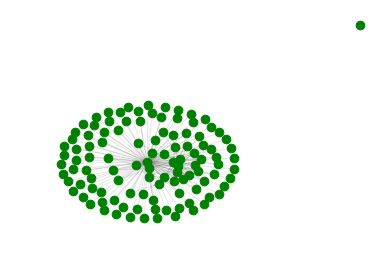

In [7]:
# plot it out
pos = nx.spring_layout(graphe_negative_avg,k=0.2)
ec = nx.draw_networkx_edges(graphe_negative_avg, pos, alpha=0.1)
nc = nx.draw_networkx_nodes(graphe_negative_avg, pos, nodelist=graphe_negative_avg.nodes(), node_color='g', cmap=plt.cm.jet, node_shape='.')
plt.axis('off')
plt.savefig('graph_negative_avg.png')
plt.show()

We observe that there is a country in the center of the graph with a lot of edges. This country is the United States. This means that for more than one hundred thousand mentions, a lot of country mentions negatively the USA.

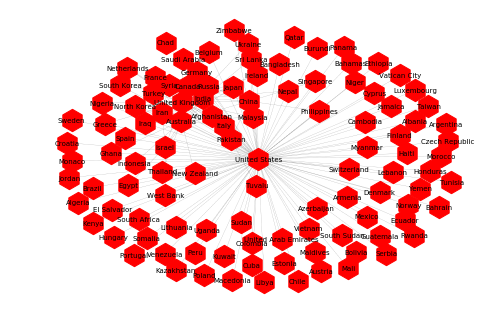

In [8]:
subgraph_USA = graphe_negative_avg.subgraph(['United States']+list(graphe_negative_avg.neighbors('United States')))
nx.draw_spring(subgraph_USA, with_labels=True, node_size=500,font_size=7, width=0.2 , node_shape="h" ,linewidths=1, style='dotted')
country_negative_USA = np.asarray(subgraph_USA.node)
df = pd.DataFrame(country_negative_USA)
df.to_csv('country_negative_USA.csv')

In [9]:
degrees = dict(subgraph_USA.degree(subgraph_USA.nodes()))
degrees['United States']

111

We can see that 111 countries talk about USA negatively with more than one hundred thousand mentions , that is huge.

In [10]:
graphe_negative_avg_story = country_to_country_view[country_to_country_view["avg_tone"] < 0][country_to_country_view["count_mentions"] > 1000000]
graphe_negative_avg_story =nx.from_pandas_edgelist(graphe_negative_avg_story, 'actor_country', 'mention_country', create_using=nx.Graph())
print(nx.info(graphe_negative_avg_story))

Name: 
Type: Graph
Number of nodes: 30
Number of edges: 38
Average degree:   2.5333


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


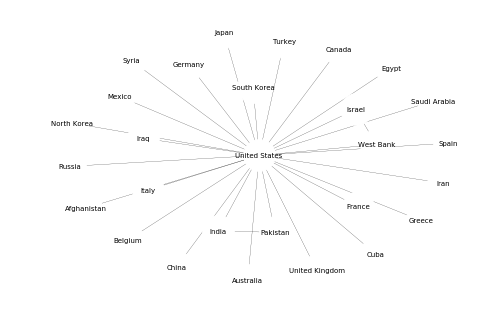

In [11]:
# Graph of the country that talk negatively about USA and with more than 1000000 mentions
subgraph_USA_lite = graphe_negative_avg_story.subgraph(['United States']+list(graphe_negative_avg_story.neighbors('United States')))
nx.draw_spring(subgraph_USA_lite, with_labels=True, node_size=1000,font_size=7, width=0.2 , node_color='w' ,linewidths=1)
country_negative_USA_lite = np.asarray(subgraph_USA_lite.node)
plt.savefig('graph_USA.png')

## Difference between country_outer_view and country_inner_view for each country 


In [12]:
# create a dataframe with two column, actor_country and difference
difference_by_country = pd.DataFrame(columns=['actor_country','difference'])
# we take all the possible name for a country
country = country_inner_view["country"].values
# for each country
for i in country:
        difference = country_outer_view[country_outer_view["country"] == i]["avg_tone"].values - country_inner_view["avg_tone"][country_inner_view["country"] == i].values
        difference_by_country = difference_by_country.append({'actor_country': i, 'difference' : difference}, ignore_index=True)

        
difference_by_country['difference'] = difference_by_country['difference'].astype(float)
#save result
difference_by_country.to_csv('difference_by_country.csv')
difference_by_country.head()

,actor_country,difference
0,Yemen,-0.802705
1,Guyana,0.261126
2,Malaysia,-1.412187
3,Singapore,0.278295
4,Iraq,-0.279156


A negative difference means that the country has a better reputation in this country than from outside

In [13]:
difference_by_country.describe()

,difference
count,183.000000
mean,-1.733244
std,1.785616
min,-9.533043
25%,-2.755870
50%,-1.482436
75%,-0.643204
max,3.612598


Text(0,0.5,'nombres')

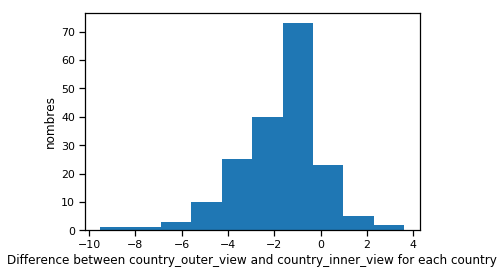

In [14]:
#plot histogram
plt.hist(difference_by_country["difference"])
plt.xlabel('Difference between country_outer_view and country_inner_view for each country')
plt.ylabel('nombres')

We can see that the histogram seems to be an histogram of a gaussian distribution. If we use describe we observe that the mean is -1.73 and the std is 1.78.

We take a look for the country who have a better inner view than outer view :

In [15]:
difference_by_country[difference_by_country["difference"] > 0]

,actor_country,difference
1,Guyana,0.261126
3,Singapore,0.278295
11,Cuba,0.993394
25,Mozambique,1.294248
32,Colombia,0.603704
38,Paraguay,2.243544
42,Chad,2.758335
57,France,0.098665
75,Lesotho,0.231544
84,Suriname,3.612598


Only 19 countries have a better reputation from outside than inside.

In [16]:
(difference_by_country[difference_by_country["difference"] < 0].count() [0] /  difference_by_country["difference"].count()) *100

89.61748633879782

90% of the coutry have better  image of them compared to the think of the other countries.

We decide to take a look to the small value of difference:

In [17]:
difference_by_country[difference_by_country["difference"] < -4]

,actor_country,difference
19,Guatemala,-4.951815
36,Anguilla,-4.711620
40,Eritrea,-4.625632
46,Djibouti,-4.764820
48,Ivory Coast,-5.790887
63,West Bank,-8.032778
66,Dominica,-5.172019
94,Laos,-4.922415
98,Turkmenistan,-4.074530
103,Democratic Republic of the Congo,-5.147711


Why such a difference ? 
We would be tempted to conclude that for each country, they have a good image of them, but the rest of the world strongly disagrees.
But if we take a closer look :

For example, we look at Anguilla :

In [18]:
Anguilla = country_to_country_view[country_to_country_view["mention_country"] == "Anguilla"]
Anguilla[Anguilla["count_mentions"] > 100 ]

,actor_country,mention_country,avg_tone,std_tone,count_mentions,count_events,avg_conf,avg_weighted_tone,std_weighted_tone,first_quartile_tone,median_tone,third_quartile_tone
1678,United States,Anguilla,1.651052,2.848094,317,311,41.356467,1.572465,3.331309,-0.225225,1.845638,3.947368
6657,United Kingdom,Anguilla,0.977449,2.199307,455,448,40.219780,1.084351,2.820023,-0.877193,0.982659,2.167183
19303,Anguilla,Anguilla,2.073790,3.367414,2242,2119,53.617306,1.819713,4.415703,0.284900,2.410800,4.205607


For Anguilla that is a British overseas territory in the Caribbean, we note that only three countries have spoken more than 100 times about this territory. The country that cited the most Anguilla it's Anguilla itself.

We can also look Dominica :

In [19]:
Dominica = country_to_country_view[country_to_country_view["mention_country"] == "Dominica"]
Dominica[Dominica["count_mentions"] > 200 ]

,actor_country,mention_country,avg_tone,std_tone,count_mentions,count_events,avg_conf,avg_weighted_tone,std_weighted_tone,first_quartile_tone,median_tone,third_quartile_tone
22274,United States,Dominica,0.678507,4.383362,343,292,53.381924,0.813914,4.716866,-2.263374,1.687764,4.069767
22455,Dominica,Dominica,1.950134,3.261322,2446,1904,56.295993,1.920815,4.008679,0.160514,2.259887,4.102564


Or Turkmenistan :

In [20]:
Turkmenistan = country_to_country_view[country_to_country_view["mention_country"] == "Turkmenistan"]
Turkmenistan[Turkmenistan["count_mentions"] > 200 ]

,actor_country,mention_country,avg_tone,std_tone,count_mentions,count_events,avg_conf,avg_weighted_tone,std_weighted_tone,first_quartile_tone,median_tone,third_quartile_tone
2431,Turkmenistan,Turkmenistan,3.204653,3.602764,4081,4049,47.779956,3.131333,4.828484,1.722282,3.296703,5.291005
6249,Turkey,Turkmenistan,3.654789,3.721535,208,208,37.115385,3.321556,4.925136,0.842697,3.479853,6.326531
6759,Russia,Turkmenistan,2.246197,4.060645,320,317,41.312500,1.993653,4.969339,-0.815494,1.946903,5.494505
14803,Uzbekistan,Turkmenistan,2.600513,3.905260,234,231,31.282051,2.616542,5.682812,0.736196,3.246753,4.716981


Same observation for Dominica and Turkmenistan, for instance the country that cited the most Dominica it's Dominica itself and only the USA cited Anguilla more than 200 times.

This short example shows us that to have a good interpretation of the avg_value , it's important to take in count other parameters such that the count_mentions for example. In this case we cannot conclude that  Dominica, Turkmenistan or Anguilla has a good image of them, but the rest of the world strongly disagrees because of the poor number of count_mentions from abroad.

Nethertheless for some countries, this analyse lead us to some good interpretation :

In [21]:
Macedonia = country_to_country_view[country_to_country_view["mention_country"] == "Macedonia"]
Macedonia.describe()

,avg_tone,std_tone,count_mentions,count_events,avg_conf,avg_weighted_tone,std_weighted_tone,first_quartile_tone,median_tone,third_quartile_tone
count,140.000000,140.000000,140.000000,140.000000,140.000000,140.000000,140.000000,140.000000,140.000000,140.000000
mean,-2.485711,2.235637,465.114286,360.007143,40.001732,-2.506498,3.602074,-3.987048,-2.596675,-1.032731
std,2.387119,1.516603,1796.945494,1369.372143,15.489915,2.494082,2.134009,2.396752,2.520090,2.995979
min,-8.333333,0.000000,1.000000,1.000000,10.000000,-8.773864,0.000000,-11.274510,-9.545455,-8.333333
25%,-3.849520,1.128074,7.750000,6.000000,33.303571,-3.909378,2.473885,-5.404008,-4.128744,-2.935421
50%,-2.354274,2.573116,46.500000,37.000000,37.184824,-2.363692,3.804344,-4.097702,-2.601307,-0.668602
75%,-1.239574,3.252724,233.250000,174.250000,43.259804,-1.232994,4.690516,-2.883194,-1.569551,0.705494
max,8.363636,6.726507,18990.000000,14368.000000,100.000000,8.363636,10.929243,8.363636,8.363636,10.687023


In [22]:
Bahrain = country_to_country_view[country_to_country_view["mention_country"] == "Bahrain"]
Bahrain.describe()

,avg_tone,std_tone,count_mentions,count_events,avg_conf,avg_weighted_tone,std_weighted_tone,first_quartile_tone,median_tone,third_quartile_tone
count,189.000000,189.000000,189.000000,189.000000,189.000000,189.000000,189.000000,189.000000,189.000000,189.000000
mean,-1.866617,3.570544,796.529101,595.899471,40.231127,-1.892825,4.939031,-4.510671,-2.059518,0.508920
std,3.035935,1.761109,2477.628206,1959.926148,11.343755,3.060059,2.092230,3.688552,3.459361,3.384353
min,-10.645658,0.000000,1.000000,1.000000,15.625000,-10.484562,0.000000,-13.366337,-13.366337,-7.759700
25%,-3.911626,2.987853,20.000000,13.000000,34.864865,-3.870653,3.842811,-6.881720,-4.497354,-1.460823
50%,-2.229975,3.947990,70.000000,46.000000,39.025522,-2.243753,5.352305,-5.263158,-2.258065,0.416667
75%,-0.481343,4.725277,419.000000,274.000000,43.459119,-0.357451,6.366726,-2.894356,-0.445434,2.857143
max,8.184143,8.670034,23694.000000,20498.000000,100.000000,8.184143,10.213191,8.184143,8.184143,9.183673


In [23]:
Eritrea = country_to_country_view[country_to_country_view["mention_country"] == "Eritrea"]
Eritrea.describe()

,avg_tone,std_tone,count_mentions,count_events,avg_conf,avg_weighted_tone,std_weighted_tone,first_quartile_tone,median_tone,third_quartile_tone
count,134.000000,134.000000,134.000000,134.000000,134.000000,134.000000,134.000000,134.000000,134.000000,134.000000
mean,-1.501866,2.480353,207.828358,186.149254,42.070011,-1.364598,3.867503,-3.154771,-1.776653,0.217768
std,3.075452,1.851814,1088.276022,933.306601,16.852837,3.077244,2.191623,3.222977,3.306307,3.767703
min,-11.810953,0.000000,1.000000,1.000000,10.000000,-9.804450,0.000000,-13.978495,-13.978495,-9.693053
25%,-3.680382,0.583439,5.000000,4.000000,33.461538,-3.304647,2.478671,-4.968505,-3.904282,-2.584313
50%,-1.731520,2.920617,17.000000,16.000000,39.199247,-1.493428,4.288754,-3.873371,-2.312216,-0.240077
75%,0.100200,3.895792,55.750000,51.250000,46.115385,0.006235,5.323078,-1.559726,-0.155925,3.103117
max,9.459459,8.223320,12081.000000,10243.000000,100.000000,9.459459,11.247898,9.459459,9.459459,11.200000


For Eritrea , Bahrain and Macedonia, the analysis is different. the difference of view within and outside this country is no longer due to a small count of event but rather in conflicts with others countries.

This example shows that we have to be very carefull about the analysis of the data and all the countries that have a bad avg_tone are not necessarily in conflict. The lack of events can lead to misinterpretation.